In [67]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [68]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

In [69]:
dataset = 'compas'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [70]:
X_train, X_test, y_train, y_test = load(dataset)

In [71]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [72]:
len(X_train)

5771

In [73]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [74]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [75]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.10664561084432223
Initial TPR parity:  0.04579037130140762
Initial predictive parity:  0.057398965624464116
Initial accuracy:  0.9085239085239085


In [76]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [77]:
del_F_del_theta.shape

(10,)

In [78]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 5771/5771 [00:29<00:00, 194.10it/s]


In [79]:
hessian_all_points.shape

(5771, 10, 10)

In [80]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [81]:
del_L_del_theta.shape

(5771, 10)

In [82]:
hessian_all_points.shape

(5771, 10, 10)

In [83]:
del_F_del_theta.shape

(10,)

In [84]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))

In [85]:
hinv_v.shape

(10, 5771)

In [86]:
del_F_del_theta.shape

(10,)

In [87]:
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)

<h4>Flip the datapoints and remove the datapoints and compare the parity values<h4>

In [88]:
#Run the LR classifier
clf = LogisticRegression(class_weight=None, max_iter=100)
lr = clf.fit(X_train_orig,y_train)
prediction = lr.predict(X_test_orig)
prediction_prob = lr.predict_proba(X_train_orig)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

90.85239085239085


In [89]:
X_train_orig

,event,priors_count,juv_other_count,juv_misd_count,juv_fel_count,race,age_cat,sex,score_text
0,0,1,2,2,0,0,1,1,2
1,0,1,0,0,0,1,1,1,0
2,0,0,0,0,0,1,1,1,0
3,1,2,0,0,2,0,1,0,2
4,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...
5766,0,0,0,0,0,1,2,0,0
5767,0,0,0,0,0,1,2,1,0
5768,0,1,0,0,0,0,2,1,0
5769,0,0,0,0,0,0,2,1,0


In [90]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def logistic_regression_updated(train_dataset, X_test_orig, y_test, independent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        training_labels = train_dataset.pop('is_recid')
        training_attributes = train_dataset
        #x = train_dataset[independent_var].values
        #y = train_dataset[dependent_var].values
        #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=310)
        clf = LogisticRegression(class_weight=None, max_iter=100)
        log = clf.fit(training_attributes,training_labels)
        prediction = log.predict(X_test_orig)

        train_dataset['is_recid'] = training_labels
        #print(train_dataset)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(X_test_orig, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [91]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [92]:
predictors = ['event', 'priors_count', 'juv_other_count', 'juv_misd_count',
       'juv_fel_count', 'race', 'age_cat', 'sex', 'score_text']
target_var = ['is_recid']

In [93]:
#Break the test dataframe into different groups
#Unprotected group is everyone who is a POC
#Protected Group is everyone who is a non-POC
test_demo_df = pd.DataFrame(X_test_orig, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['is_recid_new'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['race']==1]))
total_priv = (len(concat_df[concat_df['race']==0]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['is_recid_new'] == 1) & (concat_df['race'] == 1)])
total_credit_priv = len(concat_df[(concat_df['is_recid_new'] == 1) & (concat_df['race'] == 0)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')

Statistical Parity: 0.11639


In [94]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train_orig, columns = predictors)
train_outcome_df = y_train.to_frame()
#train_outcome_df=train_outcome_df.rename(columns={'is_recid':'is_recid'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [95]:
#Flipping the datapoints 
#.11639
flip_difference = []
for index, row in train_full_df.iterrows():
    if row['is_recid'] == 1:
        train_full_df.at[index,'is_recid'] = 0
        #training_copy = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df,X_test_orig, y_test, predictors, 'is_recid_new')
        parity = s_parity(X_test_orig, predictors, y_test, 'race', 1, 'is_recid_new')
        flip_difference.append(parity-statistical_parity)
        #print(parity)
        train_full_df.at[index,'is_recid'] = 1
        print(accuracy)
    elif row['is_recid'] == 0:
        train_full_df.at[index,'is_recid'] = 1
        #training_copy = train_full_df.copy()
        accuracy,test_demo_df,predicted_df = logistic_regression_updated(train_full_df,X_test_orig,y_test, predictors,'is_recid_new')
        parity = s_parity(test_demo_df, predictors, predicted_df, 'race', 1, 'is_recid_new')
        flip_difference.append(parity-statistical_parity)
        #print(parity)
        train_full_df.at[index,'is_recid'] = 0
        print(accuracy)

90.92169092169092
90.85239085239085
90.85239085239085
90.78309078309078
90.85239085239085
90.85239085239085
90.85239085239085
90.92169092169092
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.92169092169092
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.92169092169092
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.85239085239085
90.8523908

In [96]:
copy_train = train_full_df.copy()
remove_difference = []
for index in copy_train.index:
    #df_dropped = copy_train.copy()
    #row = copy_train.loc[[index]]
    df_dropped = copy_train.drop(index)
    #Some calculations that I need to do
    #Will contain logistic_regression() and s_parity()
    accuracy, test_demo_df, predicted_df = logistic_regression_updated(df_dropped, X_test_orig, y_test, predictors, 'is_recid_new')
    parity = s_parity(test_demo_df, predictors, predicted_df, 'race', 1, 'is_recid_new')
    remove_difference.append(parity-statistical_parity)

In [97]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]
print(decimal_array)

[0.9215407277, -0.4926648509, 1.6881045244, -0.0393947178, 1.6881045244, -0.3087544522, -0.3087544522, 0.5261657099, 0.1748900777, -0.1894535578, 0.2293489384, 0.2583017064, -0.3087544522, -0.4566933923, -0.3633884153, -0.3406359452, 0.2535534959, -0.0871542155, -0.189165667, -0.1894535578, -0.183301594, 0.2293489384, 0.4677273385, 0.2583017064, 0.4416322708, 0.2583017064, -0.0379784175, 0.5864350796, 0.1687737631, -0.4781674114, -0.8355224758, -0.2661941082, 0.1748900777, -0.2661941082, -0.0853465767, -0.1270791945, -0.0329953738, -0.6779957473, -0.3406359452, -0.1894535578, 0.1819509354, 0.1748900777, 0.1748900777, 0.1819509354, -0.7208040547, 0.3564592436, -0.4830281908, -0.6777742319, 0.1945562043, 0.1118508434, -0.3406359452, -0.3406359452, -0.1270791945, 0.2535534959, -0.3087544522, -0.0580662225, -0.5630114162, -0.4450389814, -0.0853465767, -0.4566933923, -0.203415226, -0.4781674114, -0.3087544522, 0.1277152878, -0.3087544522, 0.1748900777, 0.2583017064, -0.2971641231, 0.2535534

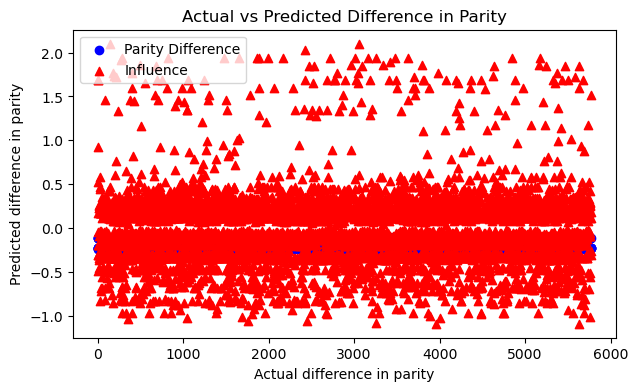

In [98]:
# Assuming the X-axis is some common range or specific values
x_values_list = range(len(flip_difference))  # X values for list data
x_values_array = range(len(inf))  # X values for ndarray data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(x_values_list, flip_difference, color='blue', label='Parity Difference', marker='o')

# Plot ndarray data with triangles
plt.scatter(x_values_array, decimal_array, color='red', label='Influence', marker='^')

# Adding labels
plt.xlabel('Actual difference in parity')
plt.ylabel('Predicted difference in parity')

# Adding title and legend
plt.title('Actual vs Predicted Difference in Parity')
plt.legend()

# Display the plot
plt.show()

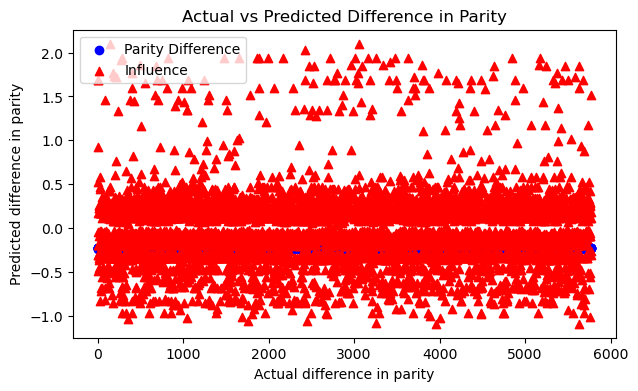

In [99]:
# Assuming the X-axis is some common range or specific values
x_values_list = range(len(remove_difference))  # X values for list data
x_values_array = range(len(inf))  # X values for ndarray data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(x_values_list, remove_difference, color='blue', label='Parity Difference', marker='o')

# Plot ndarray data with triangles
plt.scatter(x_values_array, decimal_array, color='red', label='Influence', marker='^')

# Adding labels
plt.xlabel('Actual difference in parity')
plt.ylabel('Predicted difference in parity')

# Adding title and legend
plt.title('Actual vs Predicted Difference in Parity')
plt.legend()

# Display the plot
plt.show()

In [100]:
#data that we are working with 
inf
flip_difference
remove_difference 

[-0.2338383838383839,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2338383838383839,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.232783

In [101]:
#Compare the inf and list_difference values
indices_in_range_flip = []

for i in range(len(inf)):
    diff = abs(inf[i]-flip_difference[i])

    if diff <= statistical_parity:
        indices_in_range_flip.append(i)



In [102]:
#Compare the inf and the difference values
indices_in_range_remove = []

for i in range(len(inf)):
    diff = abs(inf[i]-remove_difference[i])

    if diff <= statistical_parity:
        indices_in_range_remove.append(i)
print(indices_in_range_remove)

[5, 6, 9, 12, 15, 18, 19, 20, 31, 33, 35, 38, 39, 50, 51, 52, 54, 60, 62, 64, 67, 69, 77, 87, 90, 94, 95, 96, 97, 98, 102, 106, 107, 111, 113, 116, 117, 118, 130, 131, 147, 150, 154, 155, 156, 157, 158, 159, 161, 162, 165, 166, 170, 174, 177, 178, 179, 181, 182, 192, 201, 204, 212, 213, 214, 215, 224, 225, 227, 230, 232, 238, 239, 242, 243, 247, 259, 263, 265, 270, 275, 279, 286, 291, 294, 299, 301, 308, 310, 312, 313, 315, 316, 319, 323, 326, 330, 336, 338, 341, 347, 348, 351, 353, 354, 357, 363, 366, 370, 377, 378, 382, 393, 395, 401, 403, 413, 416, 423, 424, 427, 430, 433, 437, 447, 450, 455, 459, 464, 465, 468, 469, 471, 478, 487, 488, 492, 493, 496, 497, 500, 508, 511, 515, 527, 531, 532, 534, 536, 539, 542, 545, 546, 557, 563, 564, 571, 572, 573, 574, 575, 576, 578, 579, 580, 585, 594, 600, 607, 609, 612, 615, 616, 621, 624, 633, 638, 641, 646, 648, 651, 652, 661, 667, 672, 685, 686, 692, 701, 710, 716, 717, 720, 723, 724, 732, 733, 737, 740, 743, 745, 750, 753, 755, 756, 764, 76

In [103]:
remove_parity = []
copy_train = train_full_df.copy()
for i in range(len(indices_in_range_remove)):
    row_num = indices_in_range_flip[i]
    if row_num in train_full_df.index:
        df_dropped = copy_train.drop(row_num)
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(df_dropped, X_test_orig, y_test, predictors, 'is_recid_new')
        parity = s_parity(test_demo_df, predictors, predicted_df, 'race', 1, 'is_recid_new')
        remove_parity.append(parity-statistical_parity)
remove_parity

[-0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.2327835315177088,
 -0.232783

In [104]:
#With the indices figured out now I will go through the datasets and flip based on those indices
#copy_train_df = train_full_df.copy()
flip_parity = []
for i in range(len(indices_in_range_flip)):
    row_num = indices_in_range_flip[i]
    if train_full_df.at[row_num,'is_recid'] == 1:
        train_full_df.at[row_num,'is_recid'] = 0
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df,X_test_orig, y_test, predictors, 'is_recid_new')
        parity = s_parity(X_test_orig, predictors, y_test, 'race', 1, 'is_recid_new')
        flip_parity.append(parity)
    elif train_full_df.at[row_num,'is_recid'] == 0:
        train_full_df.at[row_num,'is_recid'] = 1
        #copy_train_df = train_full_df.copy()
        accuracy, test_demo_df, predicted_df = logistic_regression_updated(train_full_df,X_test_orig, y_test, predictors, 'is_recid_new')
        parity = s_parity(test_demo_df, predictors, predicted_df, 'race', 1, 'is_recid_new')
        flip_parity.append(parity)
flip_parity

        

[0.0,
 -0.11533691343817926,
 -0.11533691343817926,
 0.0,
 -0.11533691343817926,
 -0.11533691343817926,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.11533691343817926,
 -0.11533691343817926,
 0.0,
 0.0,
 0.0,
 -0.11533691343817926,
 0.0,
 -0.11533691343817926,
 -0.11533691343817926,
 0.0,
 -0.11533691343817926,
 0.0,
 0.0,
 0.0,
 -0.11533691343817926,
 -0.11533691343817926,
 -0.11533691343817926,
 -0.10927630737757316,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.10611175041554788,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.10611175041554788,
 0.0,
 0.0,
 -0.10611175041554788,
 0.0,
 -0.11217235647615398,
 -0.10611175041554788,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.10611175041554788,
 -0.10611175041554788,
 0.0,
 0.0,
 0.0,
 -0.10611175041554788,
 0.0,
 0.0,
 -0.10611175041554788,
 -0.10611175041554788,
 -0.10611175041554788,
 0.0,
 -0.10611175041554788,
 -0.10611175041554788,
 0.0,
 -0.10611175041554788,
 0.0,
 0.0,
 0.0,
 -0.10611175041554788,
 0.0,
 -0.10611175041554788,
 -0.10611175041554788,
 0.0,
 -0.1061117504155

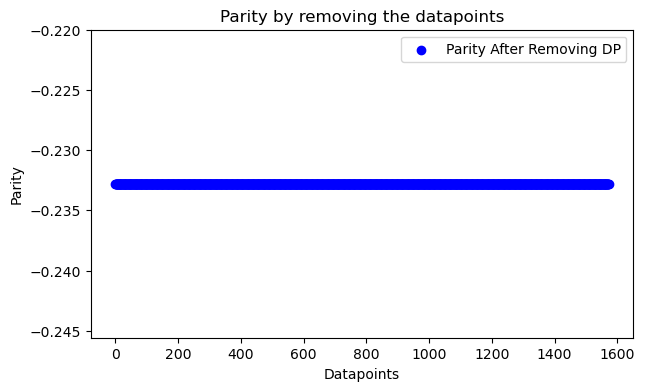

In [105]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(remove_parity))  # X values for list data


# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, remove_parity, color='blue', label='Parity After Removing DP', marker='o')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by removing the datapoints')
plt.legend()

# Display the plot
plt.show()

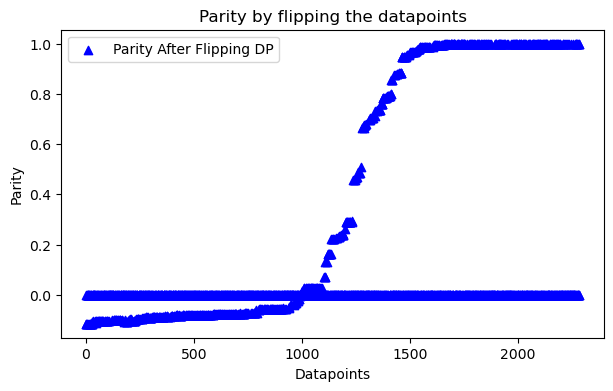

In [106]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity))  # X values for list data


# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity, color='blue', label='Parity After Flipping DP', marker='^')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints')
plt.legend()

# Display the plot
plt.show()